In [30]:
import os
import cv2
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.metrics import Recall,Precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.layers import Input,concatenate
from tensorflow.keras.models import Model 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
df=pd.read_csv(r"/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

In [4]:
df.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [6]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

<Axes: xlabel='labels', ylabel='Patient Age'>

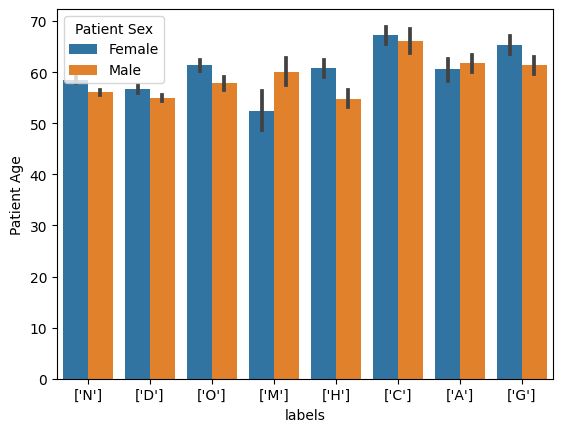

In [8]:
sns.barplot(data=df,x="labels",y="Patient Age",hue="Patient Sex")


In [9]:
if 'ID' in df.columns:   
    df=df.drop('ID',axis=1)

In [10]:
df.columns

Index(['Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [11]:
df['Patient Sex'].value_counts()

Patient Sex
Male      3424
Female    2968
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Patient Age', ylabel='Count'>

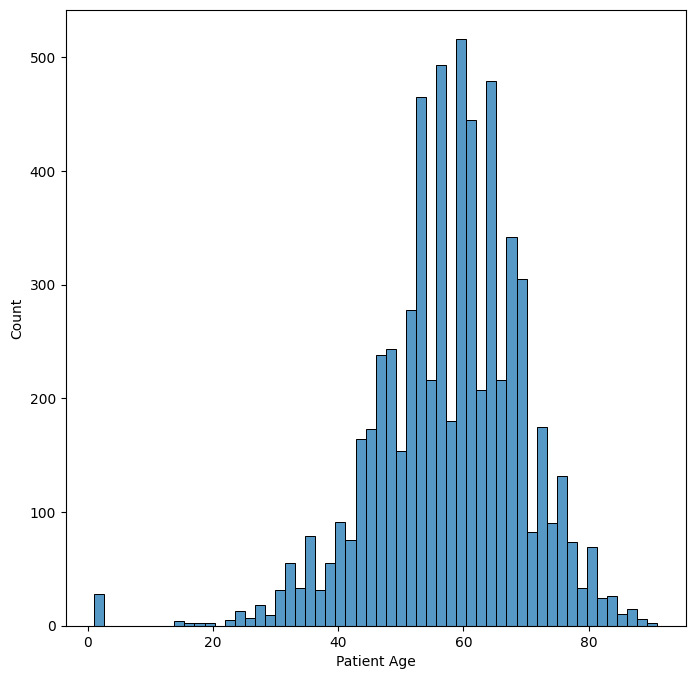

In [12]:
plt.figure(figsize=(8,8))
sns.histplot(data=df,x="Patient Age")

([<matplotlib.patches.Wedge at 0x7e94542f1f30>,
 [Text(0.2055101877331841, 1.2836532096862734, 'Normal'),
  Text(-1.0594468214361001, -0.5419155215981034, 'Diabetes'),
  Text(0.04432008452473661, -1.0991067873995322, 'Glaucoma'),
  Text(0.5582506611218526, -0.9478165430910218, 'Cataract'),
  Text(0.8011544593128657, -0.7537582718107378, 'Age related Macular Degeneration'),
  Text(0.9733436509785615, -0.5124472042071498, 'Hypertension'),
  Text(1.068511927516186, -0.2613087460374127, 'Pathological Myopia'),
  Text(1.0978239573964101, -0.0691560450465866, 'Other diseases/abnormalities')],
 [Text(0.1264678078358056, 0.7899404367300144, '44.9%'),
  Text(-0.614301098143621, -0.3142199242879759, '25.2%'),
  Text(0.024174591558947238, -0.5995127931270176, '11.1%'),
  Text(0.30450036061191954, -0.5169908416860118, '4.6%'),
  Text(0.4369933414433812, -0.41114087553312967, '4.4%'),
  Text(0.5309147187155789, -0.27951665684026356, '4.2%'),
  Text(0.5828246877361014, -0.1425320432931342, '3.6%'),


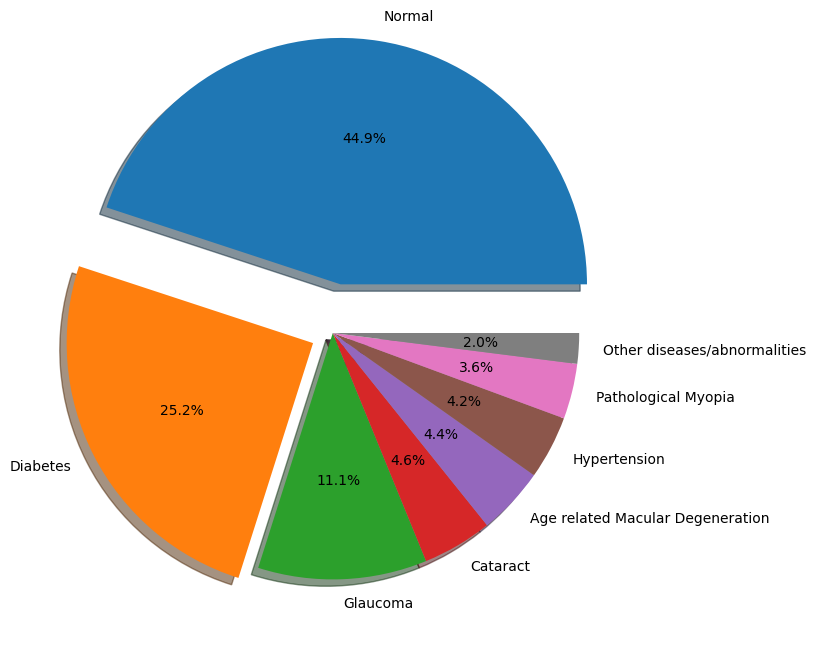

In [13]:
plt.figure(figsize=(8,8))
plt.pie(df['labels'].value_counts(),autopct="%0.1F%%",
        labels=['Normal','Diabetes','Glaucoma','Cataract','Age related Macular Degeneration','Hypertension',
                'Pathological Myopia','Other diseases/abnormalities']
                ,shadow=True,explode=[0.2,0.09,0,0,0,0,0,0]
                )

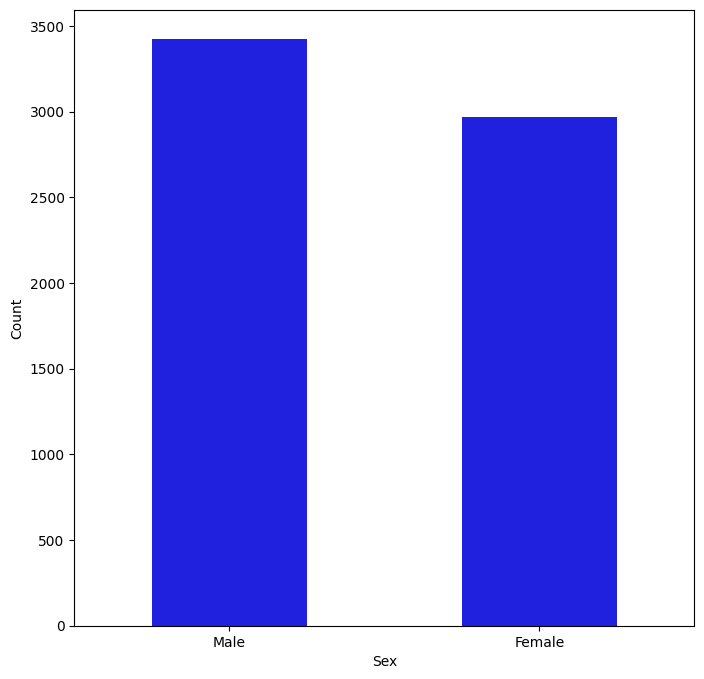

In [14]:



sex_counts = df['Patient Sex'].value_counts().reset_index()

sex_counts.columns = ['Sex', 'Count']

plt.figure(figsize=(8,8))
sns.barplot(x='Sex', y='Count', data=sex_counts, color="b", width=0.5)
plt.show()


([<matplotlib.patches.Wedge at 0x7e9453508100>,
 [Text(-0.14537232418364313, 1.2918463094971653, 'MALE'),
  Text(0.12300724888883716, -1.093100734937453, 'FEMALE')],
 [Text(-0.08945989180531883, 0.7949823443059478, '53.6%'),
  Text(0.0670948630302748, -0.5962367645113379, '46.4%')])

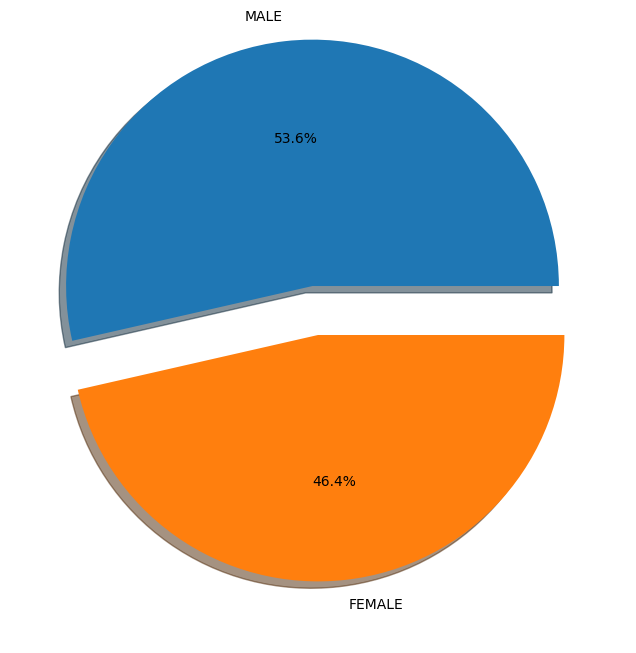

In [15]:
plt.figure(figsize=(8,8))
plt.pie(df['Patient Sex'].value_counts(),labels=["MALE","FEMALE"],autopct="%0.1f%%",shadow=True,explode=[0.2,0])

In [16]:
df.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [17]:
real_values=["['N']", "['D']", "['O']", "['M']", "['H']", "['C']", "['A']","['G']"]
df['labels'].unique()


array(["['N']", "['D']", "['O']", "['M']", "['H']", "['C']", "['A']",
       "['G']"], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])


In [19]:
df['labels'] = df['labels'].astype(str)

In [20]:
left_images=df[['Left-Fundus','labels']]
Right_images=df[['Right-Fundus','labels']]

left_images.columns=['image','target']
Right_images.columns=['image','target']
left_images

,image,target
0,0_left.jpg,6
1,1_left.jpg,6
2,2_left.jpg,2
3,4_left.jpg,2
4,5_left.jpg,2
...,...,...
6387,4686_left.jpg,2
6388,4688_left.jpg,2
6389,4689_left.jpg,2
6390,4690_left.jpg,2


In [21]:
combined_df=pd.concat([left_images,Right_images])
combined_df = combined_df.dropna(subset=['image'])
combined_df

,image,target
0,0_left.jpg,6
1,1_left.jpg,6
2,2_left.jpg,2
3,4_left.jpg,2
4,5_left.jpg,2
...,...,...
6387,4686_right.jpg,2
6388,4688_right.jpg,2
6389,4689_right.jpg,2
6390,4690_right.jpg,2


In [22]:
train_df,test_df=train_test_split(combined_df,test_size=0.2,random_state=42)
train_df.head()

,image,target
5328,3007_right.jpg,6
108,128_right.jpg,7
4023,950_left.jpg,6
3189,4686_right.jpg,2
1494,2231_right.jpg,1


In [23]:
datagen=ImageDataGenerator(rescale=1./255)

In [24]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images',
    x_col='image',
    y_col='target',
    subset="training",
    class_mode="categorical",
    target_size=(224,224),
    batch_size=16
)

Found 10227 validated image filenames belonging to 8 classes.


In [25]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images',
    x_col="image",
    y_col="target",
    # subset="validation",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=32
    )



Found 2557 validated image filenames belonging to 8 classes.


In [26]:
input_layer = Input(shape=(224, 224, 3))

resnet50 = ResNet50(weights='imagenet', include_top=False)(input_layer)
flatten_50 = Flatten()(resnet50)

resnet152 = ResNet152(weights='imagenet', include_top=False)(input_layer)
flatten_152 = Flatten()(resnet152)

merged = concatenate([flatten_50, flatten_152])

dense1 = Dense(512, activation='relu')(merged)
dense2 = Dense(256, activation='relu')(dense1)
dense3=Dense(128,activation='relu')(dense2)
dense4=Dense(64,activation='relu')(dense3)
output_layer = Dense(8, activation='softmax')(dense4)

model = Model(inputs=input_layer, outputs=output_layer)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [28]:

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[
                  Recall(name="recall"),
                  Precision(name="Precision"),
                  "accuracy"
                    ])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 7, 7,      │ 58,370,944 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 100352)    │          0 │ resnet152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200704)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 102,760,9… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        520 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,892,616 (705.31 MB)

 Trainable params: 184,688,072 (704.53 MB)

 Non-trainable params: 204,544 (799.00 KB)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)


In [38]:
# checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)
# history = model.fit(train_generator, epochs=10, validation_data=validation_generator,callbacks=[model_checkpoint_callback])
# history = model.fit(train_generator, epochs=20, validation_data=validation_generator,callbacks=[early_stopping])  
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)   

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 293s 454ms/step - Precision: 0.8678 - accuracy: 0.8455 - loss: 0.3345 - recall: 0.8253 - val_Precision: 0.6242 - val_accuracy: 0.6105 - val_loss: 1.7826 - val_recall: 0.5905
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 304s 471ms/step - Precision: 0.8724 - accuracy: 0.8522 - loss: 0.3231 - recall: 0.8339 - val_Precision: 0.6385 - val_accuracy: 0.6293 - val_loss: 2.3040 - val_recall: 0.6203
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 311s 483ms/step - Precision: 0.8717 - accuracy: 0.8591 - loss: 0.3022 - recall: 0.8408 - val_Precision: 0.5330 - val_accuracy: 0.5327 - val_loss: 5.6761 - val_recall: 0.5299
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 316s 490ms/step - Precision: 0.8736 - accuracy: 0.8603 - loss: 0.2983 - recall: 0.8446 - val_Precision: 0.6522 - val_accuracy: 0.6418 - val_loss: 1.8854 - val_recall: 0.6293
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 312s 482ms/step - Precision: 0.8683 - accuracy: 0.8524 - loss: 0.3085 - recall: 0.8378 - val_Precision: 

In [ ]:
model.save("eyes_ResNet_1:30_v2.h5") 
